**<center><h1>Deep Learning Approaches to Natural Language Processing</h1></center>**
**<center><h2>Text Compression Assignment</h2></center>**
**<center><h3>Matthias Bartolo</h3></center>**

<br>

### Package imports

In [1]:
# Suggested imports. You may add your own here.

%matplotlib inline

import collections
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
from collections import Counter

# Variable to control the size of the print statements
print_size = 87

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Text compression assignment

It is said that you can measure the intelligence of an AI from the amount it can compress a text without information loss.
One way to think about this is that, the more a text is predictable, the more words we can leave out of it as we can guess the missing words.
On the other hand, the more intelligent an AI is, the more it will find texts to be predictable and so the more words it can leave out and guess.
This has led to a competition called the [Hutter Prize](http://prize.hutter1.net/) where the objective is to compress a given text as much as possible.
The record for compressing a 1GB text file extracted from a Wikipedia snapshot is about 115MB.
The main hurdle here is that the program used to decompress the file must be treated as part of the compressed file, meaning that the program itself must also be small.

In this assignment, you're going to be doing something similar using a smaller text file and using neural language models to guess missing words.

## 1) Data processing (10%)

You have a train/dev/test split corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line and each sentence has been tokenised for you such that tokens are space separated.
This means that you only need to split by space to get the tokens.
The text has all been lowercased as well.
The objective here is to be able to compress the text losslessly, meaning that it can be decompressed back to the original string:

$$\text{decompress}(\text{compress}(t)) = t$$

Do not do any further pre-processing on the text (such as stemming) as it may result in unrecoverable information loss.
The test set is what we will be compressing and will not be processed at all as it will be treated as a single big string by the compression/decompression algorithms.

Do the following tasks:

1.1) Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).
Do not load the test set.

In [2]:
def load_into_sentences(filename):
    """Loads the file with the given filename into a list of sentences.
    
    Args:
        filename (str): The filename to load.
        
    Returns:
        list: A list of sentences, where each sentence is a list of words.
    """
    # Opening file and reading lines. Stripping each line of whitespace and newlines.
    with open(filename, encoding='utf-8') as f:
        sentences = f.readlines()

        # Splitting the line by spaces and stripping each word of whitespace and newlines.
        sentences = [sentence.split() for sentence in sentences]

    # Returning the list of sentences.
    return sentences

In [3]:
# Loading the data into lists of sentences.
dev_sentences = load_into_sentences('dev.txt')
train_sentences = load_into_sentences('train.txt')

<h4> What are the uses of the different txt files? </h4>
<ul>
    <li> <b>train.txt</b> is used to train the model </li>
    <li> <b>dev.txt</b> is used to validate the model </li>
    <li> <b>test.txt</b> is used to test the model </li>
</ul>

In [4]:
print('\033[1m' + 'Number of sentences in dev set:' + '\033[0m' + ' {}'.format(len(dev_sentences)))
print('\033[1m' + 'The dev set contains the following sentences:' + '\033[0m' + ' {}'.format(dev_sentences))
print('\033[1m' + 'Number of sentences in train set:' + '\033[0m' + ' {}'.format(len(train_sentences)))
print('\033[1m' + 'The train set contains the following sentences:' + '\033[0m' + ' {}'.format(train_sentences))

Number of sentences in dev set: 1712
The dev set contains the following sentences: [['jones', 'viewed', 'the', 'resolution', 'as', 'the', 'framework', ',', 'and', 'not', 'the', 'final', 'solution', ',', 'for', 'enabling', 'librarians', 'to', 'confront', 'issues', 'that', 'hampered', '``', 'human', 'freedom', "''", '.'], ['he', 'lives', 'in', 'ottawa', ',', 'where', 'he', 'composes', 'full-time', '.'], ['many', 'natural', 'gas', 'pipelines', 'span', 'the', 'country', "'s", 'territory', '.'], ['until', 'recently', ',', 'the', 'study', 'of', 'sign', 'language', 'and', 'sociolinguistics', 'has', 'existed', 'in', 'two', 'separate', 'domains', '.'], ['in', 'the', 'house', 'of', 'commons', 'she', 'sat', 'on', 'the', 'commons', 'reference', 'group', 'on', 'representation', 'and', 'inclusion', 'and', 'previously', 'sat', 'on', 'the', 'consolidation', 'bills', '(', 'joint', 'committee', ')', 'and', 'women', 'and', 'equalities', 'committee', '.'], ['he', 'won', 'a', 'number', 'of', 'significant',

1.2) Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of your vocabulary.
Also output the most frequent vocabulary token in the train set, which should be 'the'.
Include the edge token, unknown token, and pad token in the vocabulary.

In [5]:
# The following constants were created to store the respective token values:
EDGE_TOKEN = '<EDGE>'
UNKNOWN_TOKEN = '<UNK>'
PADDING_TOKEN = '<PAD>'

In [6]:
def extract_vocabulary(sentences):
    """Extracts the vocabulary from the given sentences, for tokens that occur at least 3 times.
    
    Args:
        sentences (list): A list of sentences, where each sentence is a list of words.
        
    Returns:
        vocabulary (set): The vocabulary, containing tokens that occur at least 3 times.
        size: The size of the vocabulary.
        most_freq_token: The most frequent token in the vocabulary.
    """
    # Adding the edge, unknown and pad tokens to the vocabulary
    vocabulary = [EDGE_TOKEN, UNKNOWN_TOKEN, PADDING_TOKEN]

    # Counting the number of times each token occurs in the sentences
    counter = collections.Counter([token for sentence in sentences for token in sentence])

    # Adding all tokens that occur at least 3 times to the vocabulary
    vocabulary += [token for token, count in counter.items() if count >= 3]

    # Sorting the vocabulary
    vocabulary.sort()

    # Creating a set of the vocabulary
    vocabulary = set(vocabulary)
    
    # Retrieving the most frequent token
    most_freq_token = max(counter, key=counter.get)

    # Returning the vocabulary, its size and the most frequent token
    return vocabulary, len(vocabulary), most_freq_token

In [7]:
# Extracting the vocabulary from the train set sentences
train_vocab, train_vocab_size, train_most_freq_token = extract_vocabulary(train_sentences)

In [8]:
print('\033[1m' + 'Size of vocabulary in train set:' + '\033[0m' + ' {}'.format(train_vocab_size))
print('\033[1m' + 'Most frequent token in train set:' + '\033[0m' + ' {}'.format(train_most_freq_token))
print('\033[1m' + 'The vocabulary of the train set:' + '\033[0m' + ' {}'.format(train_vocab))

Size of vocabulary in train set: 7874
Most frequent token in train set: the
The vocabulary of the train set: {'copyright', 'aspect', 'clothing', 'requires', 'archdiocese', 'eighth', 'pushed', 'disabled', 'antennae', 'hire', 'indicating', 'thought', 'total', '#', 'dawit', 'il-', 'obtain', 'exceptions', 'raped', 'slogan', 'surrounding', 'dover', 'compound', 'falling', 'nd', 'walk', 'shades', 'dela', 'brunswick', 'runway', 'beaches', 'arsenal', 'deployment', 'complicated', 'breeding', 'worn', 'vectors', 'hamburg', 'grains', 'recurring', 'triggering', 'widely', 'architecture', 'opened', 'sands', 'assurance', 'major', 'peer-reviewed', 'virus', 'voiced', 'allegedly', 'controlled', 'filmmakers', 'submission', 'southwest', 'proceedings', 'staircase', 'telephone', 'gameplay', 'subjected', 'boy', 'lying', 'dawn', 'thorax', 'deutsche', 'hull', 'et', 'elephant', 'inverness', 'partially', 'depending', 'recognizes', 'compensation', 'theatre', 'salt', 'shoes', 'wire', 'plan', 'vocals', 'reformed', 'p

1.3) Process the loaded token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.
Do not do this for the test set as well.

In [9]:
# Creating a constant to set as the normalized length, assuming that the max length is the length of the longest sentence in the train set
MAX_LENGTH = max([len(sentence) for sentence in train_sentences])
print('\033[1m' + 'The maximum length of a sentence in the train set, excluding EDGE Token is:' + '\033[0m' + ' {}'.format(MAX_LENGTH))

The maximum length of a sentence in the train set, excluding EDGE Token is: 50


In [10]:
def match_tokens(token, vocabulary):
    """Matches the given token to the corresponding token in the vocabulary.
    
    Args:
        token (str): The token to process.
        vocabulary (set): The vocabulary to match the token to.
        
    Returns:
        str: The processed token.
    """
    # If the token is in the vocabulary, return it
    if token in vocabulary:
        return token
    # If the token is not in the vocabulary, return the unknown token
    else:
        return UNKNOWN_TOKEN

In [11]:
def process_sentences(sentences, index_flag="x_indexes"):
    """Processes the given sentences through the use of the respective functions.
    
    Args:
        sentences (list): A list of sentences, where each sentence is a list of words.
        index_flag (str): A flag to determine whether to return the x_indexes or y_indexes.
        
    Returns:
        list: A list of sentences, where each sentence is a list of words.
    """
    # Processing each sentence
    processed_sentences = []

    # Processing each sentence
    for sentence in sentences:
        # Processing each token in the sentence
        processed_sentence = [match_tokens(token, train_vocab) for token in sentence]
        
        # Adding the processed sentence to the list of processed sentences, with the edge tokens and padding tokens, depending on the index_flag
        if index_flag == "y_indexes":
            processed_sentences.append(processed_sentence + [EDGE_TOKEN] + [PADDING_TOKEN]*(MAX_LENGTH-len(processed_sentence)))
        else:
            processed_sentences.append([EDGE_TOKEN] + processed_sentence + [PADDING_TOKEN]*(MAX_LENGTH-len(processed_sentence)))
        
    # Returning the list of processed sentences
    return processed_sentences

In [12]:
# Processing the dev and train set sentences
dev_sentences_x_indexes = process_sentences(dev_sentences)
dev_sentences_y_indexes = process_sentences(dev_sentences, index_flag="y_indexes")
train_sentences_x_indexes = process_sentences(train_sentences)
train_sentences_y_indexes = process_sentences(train_sentences, index_flag="y_indexes")

In [13]:
print('\033[1m' + 'The processed dev set contains the following sentences:' + '\033[0m')
for sentence in dev_sentences_x_indexes:
    print(sentence)

The processed dev set contains the following sentences:
['<EDGE>', 'jones', 'viewed', 'the', 'resolution', 'as', 'the', 'framework', ',', 'and', 'not', 'the', 'final', 'solution', ',', 'for', '<UNK>', '<UNK>', 'to', '<UNK>', 'issues', 'that', '<UNK>', '``', 'human', 'freedom', "''", '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<EDGE>', 'he', 'lives', 'in', '<UNK>', ',', 'where', 'he', '<UNK>', 'full-time', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<EDGE>', 'many', 'natural', 'gas', '<UNK>', '<UNK>', '

In [14]:
print('\033[1m' + 'The processed train set contains the following sentences:' + '\033[0m')
for sentence in train_sentences_x_indexes:
    print(sentence)

The processed train set contains the following sentences:
['<EDGE>', 'dr.', '<UNK>', 'mcdonald', 'is', 'a', 'life', 'long', '<UNK>', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<EDGE>', 'he', 'received', 'his', 'ba', 'in', 'chemistry', ',', '<UNK>', '<UNK>', '<UNK>', ',', 'from', '<UNK>', 'college', 'in', '1', '9', '8', '1', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<EDGE>', 'the', 'growth', 'of', 'twin', 'cities', 'international', 'air

1.4) Finally, load the test set text file as single string and keep it in a variable.

In [15]:
def load_into_string(filename):
    """Loads the file with the given filename into a string.
    
    Args:
        filename (str): The filename to load.
        
    Returns:
        str: The string loaded from the file.
    """
    # Opening file and reading lines. Stripping each line of whitespace and newlines.
    with open(filename, encoding='utf-8') as f:
        text = f.read()

    # Removing whitespace and newlines from each sentence
    text = text.strip()

    # Returning the string
    return text

In [16]:
# Loading the test set into a string
test_set = load_into_string('test.txt')

In [17]:
print('\033[1m' + 'Length of test text:' + '\033[0m' + ' {}'.format(len(test_set)))
print('\033[1m' + 'The test set:' + '\033[0m' + ' {}'.format(test_set))

Length of test text: 218470
The test set: this coincidence enabled freemasons to wear the forget-me-not badge as a secret sign of membership .
3 4 . 6 % of all households were made up of individuals , and 1 5 . 7 % had someone living alone who was 6 5 years of age or older .
in 2 0 1 1 , she wrote to the federal health minister outlining the seriousness of the problem , which she said `` is a form of
in 2 0 0 8 , he sang `` l.u.v . ''
at the time , he was already committed to another nbc midseason replacement comedy , `` come to papa '' , but the series was quickly canceled , allowing his full commitment to `` the office '' .
at the 2 0 0 6 census , its population was 8 1 , in 1 9 families .
other musicians in the band during the later period were bassists percy jones ( of brand x ) and steve cook , saxophonists alan wakeman and ray warleigh , and violinist ric sanders .
corbett said he had `` a mastery of the english language '' .
ivan is out on nightly patrol of the boundary when an 

## 2) Evaluation tools (10%)

We're going to need a function that evaluates our language models as well as a way to test this function before we make the language model.
To test the evaluation function, you need to make a mock model which can be used exactly like a language model but that works with some simple rules.
This mock model will then be used to check the evaluation, compression, and decompression functions before we've developed the language model.

In this assignment, a language model function assumes the following signature:

* A parameter `x_indexes` being a tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* Returns a tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.

Do the following tasks:

2.1) Develop a mock language model.
This language model will be a module that predicts the next token after every token using these rules:

* If the actual previous token (not the predicted one) was 'the' then predict that the current token is 'dog'.
* Otherwise, predict that the current token is 'the'.

Remember that it is logits that will be returned by the forward function, not probabilities.
**Give the token being predicted a logit of 2 and all other tokens a logit of 0.**
The name of this class should be `MockModel`.

Hints:

* Feel free to use `for` loops and `if` statements.
* Remember that `x_indexes` is a tensor of previous tokens.
    For example, if `x_indexes` is `[[1, 3]]`, this is saying that the first token to predict has a previous token being 1 and the second token to predict has a previous token being 3.

Some test code has been provided to check that your mock model is correct.
Fix the test code as instructed in the comments.


</br>
<h4> What is the difference between logits and probabilities? </h4>
<ul>
    <li> <b>Logits</b> are the raw predictions that a classification model generates, which are then passed to a normalization function. </li>
    <li> <b>Probabilities</b> are the normalized output of a classification model after it has been processed by a softmax function. </li>
</ul>

In [18]:
# Creating a token to index mapping for the vocabulary
token2index = {token: index for index, token in enumerate(train_vocab)}

In [19]:
def get_index(token, index_mapping):
    """Takes a token and returns the corresponding index.
    
    Args:
        token (str): The token to process.
        index_mapping (dict): A dictionary mapping tokens to indices.
        
    Returns:
        int: The index of the token.
    """
    # If the token is in the index_mapping, return its index, else return the index of the unknown token
    return index_mapping.get(token, index_mapping[UNKNOWN_TOKEN])

In [20]:
class MockModel(torch.nn.Module):
    """A mock model that predicts the next token in a sequence.
    
    Model Rules:
    - If the previous token was 'the', predict 'dog'.
    - Otherwise predict 'the'.
    
    """
    def __init__(self, vocab_size, index_of_edge, index_of_the, index_of_dog):
        super().__init__()
        self.vocab_size = vocab_size
        self.index_of_edge = index_of_edge
        self.index_of_the = index_of_the
        self.index_of_dog = index_of_dog
        
    def forward(self, x_indexes):
        """Predicts the next token in the sequence.

        Args:
            x_indexes (torch.Tensor): A tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
                                    The tensor is of type `int64` with shape `(batch size, time steps)`
        Returns:
            torch.Tensor: A tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
                                    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.
        """
        # Creating an empty list to store the logits
        logits = []

        # Iterating through the inputted tensor sentences
        for sentence in x_indexes:
            # Creating an empty list to store the logits for each token in the sentence
            sentence_logits = []

            # Iterating through the tokens in the batch
            for token in sentence:
                # Respective if conditions for the rules of the model
                if token == self.index_of_the:  # If the current token is 'the', predict 'dog'
                    # Creating a tensor with the prediction for 'dog' (logit of 2.0)
                    next_token_logits = torch.full((self.vocab_size,), 0.0, dtype=torch.float32, device=device)
                    next_token_logits[self.index_of_dog] = 2.0
                else:  # Otherwise predicting 'the'
                    # Creating a tensor with the prediction for 'the' (logit of 2.0)
                    next_token_logits = torch.full((self.vocab_size,), 0.0, dtype=torch.float32, device=device)
                    next_token_logits[self.index_of_the] = 2.0
                
                # Appending the logits for the token to the list of logits for the sentence
                sentence_logits.append(next_token_logits)

            # Appending the logits for the sentence to the list of logits
            logits.append(torch.stack(sentence_logits))

        # Returning the logits
        return torch.stack(logits)

In [21]:
vocab_size = len(train_vocab) # You can change this to whatever code gives you the vocabulary size.
index_of_edge = get_index(EDGE_TOKEN, token2index) # You can change this to whatever code gives you the index of the edge token.
index_of_the = get_index('the', token2index) # You can change this to whatever code gives you the index of the token 'the'.
index_of_dog = get_index('dog', token2index) # You can change this to whatever code gives you the index of the token 'dog'.
mock_model = MockModel(vocab_size, index_of_edge, index_of_the, index_of_dog) # You can change these parameters as you wish.
mock_model.to(device)

mock_x_indexes = torch.tensor([
    [index_of_edge, index_of_dog, index_of_the, index_of_the],
    [index_of_edge, index_of_the, index_of_dog, index_of_dog],
], dtype=torch.int64, device=device)

mock_expected_logits = torch.zeros((2, 4, vocab_size), dtype=torch.float32, device=device)
mock_expected_logits[0, 0, index_of_the] = 2
mock_expected_logits[0, 1, index_of_the] = 2
mock_expected_logits[0, 2, index_of_dog] = 2
mock_expected_logits[0, 3, index_of_dog] = 2
mock_expected_logits[1, 0, index_of_the] = 2
mock_expected_logits[1, 1, index_of_dog] = 2
mock_expected_logits[1, 2, index_of_the] = 2
mock_expected_logits[1, 3, index_of_the] = 2

mock_logits = mock_model(mock_x_indexes)
assert mock_logits.shape == mock_expected_logits.shape, 'Output shape is invalid.'
assert mock_logits.dtype == mock_expected_logits.dtype, 'Output data type is invalid.'
assert np.unique(mock_logits.detach().cpu().numpy()).tolist() == [0.0, 2.0], 'Output has values other than 0 and 2'
assert (mock_logits == mock_expected_logits).all(), 'Output has the the wrong logits.'
print('\033[1m' + 'Correct!' + '\033[0m')

Correct!


2.2) Next, we need a function that measures the perplexity of a language model on the dev set.
Your function must take a model and a data set of token indexes and return the perplexity over the entire data set.

Hints:

* Don't forget that the perplexity includes the probability of the edge token at the end of the sentence.
* Don't forget to ignore pad tokens.

Use this function to find the mock model's perplexity on the dev set, which should be equal to `7062.2`.

In [22]:
def create_tensor(dataset, index_mapping):
    """Creates a tensor from the given dataset.
    
    Args:
        dataset (list): A list of sentences, where each sentence is a list of words.
        index_mapping (dict): A dictionary mapping tokens to indices.
        
    Returns:
        tensor: A tensor of the given indexes.
    """
    # Returning the tensor of the given indexes
    return torch.tensor(
            [
                [get_index(token, index_mapping) for token in sentence] # Retrieving the index of each token in the sentence
                for sentence in dataset # Iterating through each sentence in the dataset
            ],
            dtype=torch.int64, device=device
        )

In [23]:
# Creating respective dataset tensors
dev_x_indexes = create_tensor(dev_sentences_x_indexes, token2index)
dev_y_indexes = create_tensor(dev_sentences_y_indexes, token2index)
train_x_indexes = create_tensor(train_sentences_x_indexes, token2index)
train_y_indexes = create_tensor(train_sentences_y_indexes, token2index)

In [24]:
def measure_perplexity(x_indexes, y_indexes, model, index_mapping):
    """Takes a tensor of token indexes and measures the perplexity of the model on the dataset.
    
    Args:
        X_indexes (Tensor): A tensor of token indexes of a batch of sentences, starting with the edge token.
                            The tensor is of type `int64` with shape `(batch size, time steps)`
        y_indexes (Tensor): A tensor of token indexes of a batch of sentences, ending with the edge token.
                            The tensor is of type `int64` with shape `(batch size, time steps)`
        model: The language model.
        index_mapping (dict): A dictionary mapping tokens to indices.
        
    Returns:
        float: The perplexity of the language model on the dataset.
    """
    # Initializing perplexity
    perplexity = 0.0
    
    # Pad tokens will be ignored in the perplexity calculation
    pad_token = get_index(PADDING_TOKEN, index_mapping)
    
    # Calculating the perplexity, setting the model to not train
    with torch.no_grad():
        # Creating a tensor of the logits for the dataset
        logits = model(x_indexes)

        # Measuring the perplexity using cross entropy loss (Note that the ignore_index is being used instead of the pad_mask, as it is more efficient computationally)
        perplexity = torch.nn.functional.cross_entropy(logits.transpose(1, 2), y_indexes, ignore_index=pad_token).exp().item()

    # Returning the perplexity
    return perplexity

In [25]:
# Measuring the perplexity of the mock model on the dev set
perplexity = measure_perplexity(dev_x_indexes, dev_y_indexes, mock_model, index_mapping=token2index)
print('\033[1m' + 'The perplexity of the mock model on the dev set:' + '\033[0m' + ' {:.1f}'.format(perplexity))

The perplexity of the mock model on the dev set: 7062.2


## 3) Compression and decompression (20%)

We will now write the code that makes the actual compression and decompression of a text.

The compression algorithm will work as follows:

* You have a string of text to compress called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens` and a list of corresponding token indexes called `indexes`.
* Use `model` on `indexes` to produce `predicted`, a list of predicted next tokens for every index in `indexes`.
    A predicted next token is just the most probable token according to `model`.
* If a token in `predicted` corresponds to a token in `tokens`, then that token can be predicted by the model from its previous tokens.
    In this case, we don't need to have the token written down as it can be predicted, so we replace it in `tokens` with the single letter 'X' to say that a token should be predicted here.
    If 'X' is shorter than the replaced token, then the text will become shorter.
    Since all the text in our data sets is in lowercase, there will never be an 'X' in a sentence, so we can safely use it as a flag.
* If the token isn't correctly predicted then we leave the token in the text as-is.
* After all predictable tokens in `tokens` have been replaced with an 'X', return `tokens` as a space separated string.

The decompression algorithm will work as follows:

* You have a string of compressed text called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens`.
* Go through the tokens in `tokens` from the front and stop at the first 'X'.
* Convert all the tokens before the 'X' to token indexes called `indexes`.
* Use `model` to predict what the most probable token at the end of `indexes` would be.
* Replace the 'X' in `tokens` with this most probable token.
* Repeat this for every 'X'.
* After all 'X' are replaced in `tokens`, return `tokens` as a space separated string.

Do the following tasks:

3.1) Start with the compression function.
The input text will consist of sentences separated by new lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
Remember that we want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as-is (**there must not be any unknown tokens in the output**).

Print out the result of compressing this sentence using the mock model:

`the dog bit the cat sensually .`

which should be compressed into:

`X X bit X cat sensually .`

Hints:

* You don't need to follow the algorithm described above exactly (you can use different variable names and you can use new variables).
* Don't forget that out of vocabulary tokens still need to be replaced with the unknown token when creating the token indexes.
    What you can't do is return unknown tokens in the compressed output.
* The most probable token index for all token positions at once can be found from the logits by using `.argmax(1)`.
* Do not compare the token indexes of the uncompressed sentence to the predicted token indexes as otherwise the unknown token can be considered a correct prediction.
    Instead, compare the predictions with the string tokens in the uncompressed sentence.

In [26]:
def compress(text, model, index_mapping):
    """Compresses the given text using the given model.

    Args:
        text (str): The text to compress, which consists of sentences separated by new lines and space separated tokens.
        model: The language model. 
        index_mapping (dict): A dictionary mapping tokens to indices. 

    Returns:
        str: The compressed text.
    """
    # Extracting a list of tokens for each sentence in the text, splitting by new lines first, then by spaces
    sentences = [sentence.split() for sentence in text.split('\n')]

    # Retrieving the maximum length of a sentence in the calculated sentences
    max_length = max([len(sentence) for sentence in sentences])

    # Creating dictionary to map indices to tokens
    index2token = {index: token for token, index in index_mapping.items()}

    # Creating a multi-sized tensor of the indexes of the tokens in the sentences
    x_indexes = torch.tensor(
        [
            [get_index(EDGE_TOKEN, index_mapping)] +
            [get_index(token, index_mapping) for token in sentence] +
            [get_index(PADDING_TOKEN,index_mapping)] * (max_length - len(sentence))
            for sentence in sentences # Including all the above constructs in a list comprehension
        ],
        dtype=torch.int64,
        device=device
    )

    # Predicting the logits for the tokens to produce a tensor
    predicted = model(x_indexes)

    # Looping through the predicted logits, and for each sentence, predicting the next token
    for i in range(len(predicted)):
        # Predicting the next token for each token in the sentence
        predicted_tokens = torch.argmax(predicted[i], dim=1)

        # Looping through the tokens in the sentence
        for j in range(len(sentences[i])):
            # If the predicted token is the same as the original token, then set the original token to 'X'
            if index2token[predicted_tokens[j].item()] == sentences[i][j]:
                sentences[i][j] = 'X' # Setting the token to 'X' as X is only 1 character long and thus space will be saved

    # Joining the tokens into a string and returning compressed text
    compressed_text = '\n'.join([' '.join(sentence) for sentence in sentences])

    # Returning the compressed text
    return compressed_text

In [27]:
# Compressing the test set using the mock model
test_text = "the dog bit the cat sensually ."
compressed_text = compress(test_text, mock_model, index_mapping=token2index)

print('\033[1m' + 'Original text:' + '\033[0m' + ' {}'.format(test_text))
print('\033[1m' + 'Compressed text:' + '\033[0m' + ' {}'.format(compressed_text))

Original text: the dog bit the cat sensually .
Compressed text: X X bit X cat sensually .


3.2) Now write the decompression function.
Again, The input text will consist of sentences separated by new lines and space separated tokens, only this time, some of those tokens will be an 'X'.
The function should return a single big string where each line in the compressed text is decompressed back into the original input line.

Print out the result of decompressing the compressed text:

`X X bit X cat sensually .`

which should be decompressed into:

`the dog bit the cat sensually .`

Hints:

* You cannot use the language model once to predict all 'X's at once because the sentence prefix leading up to the 'X' must not have another 'X' in it.
    So you have to make a separate language model prediction for every 'X' using only the tokens that come before 'X' as input to the language model (plus the edge token at the front).
* Don't forget that the input to the language model cannot contain 'X's, so make sure that you're replacing those 'X's with their predicted token when constructing the language model input.


In [28]:
def decompress(text, model, index_mapping):
    """Decompresses the given text using the given model.

    Args:
        text (str): The text to decompress, which consists of sentences separated by new lines and space separated tokens.
        model: The language model. 
        index_mapping (dict): A dictionary mapping tokens to indices. 

    Returns:
        str: The decompressed text.
    """
    # Extracting a list of tokens for each sentence in the text, splitting by new lines first, then by spaces
    sentences = [sentence.split() for sentence in text.split('\n')]

    # Creating a dictionary to store the token of each index
    index2token = {index: token for token, index in index_mapping.items()}
    
    # Looping through all the sentences
    for sentence_no, sentence in enumerate(sentences):
        # Making a copy of the original sentence
        original_sentence = sentence[:]
        
        # Looping through all the tokens, and once a token is 'X', convert the tokens to indices
        for token_no, token in enumerate(sentence):
            # If the token is 'X', then convert the token to the index of the predicted token
            if token == 'X':
                # Creating a tensor of the indexes of the tokens, adding the edge token to the beginning, and only taking the tokens before the 'X' token
                x_indexes = torch.tensor([get_index(EDGE_TOKEN, index_mapping)] + [get_index(token, index_mapping) for token in original_sentence[:token_no]], dtype=torch.int64, device=device)
                
                # Predicting the logits for the tokens to produce a list
                predicted = model(x_indexes.unsqueeze(0))[0]

                # Retrieving the index of the token with the highest probability through the argmax function
                predicted = torch.argmax(predicted, dim=1)

                # Retrieving the token from the index (the last token in the list)
                new_token = index2token[predicted[-1].item()]
                
                # Replacing the 'X' token with the new token in the original sentence
                original_sentence[token_no] = new_token
        
        # Replacing the modified sentence back in the 'sentences' list
        sentences[sentence_no] = original_sentence

    # Joining the tokens into a string and returning compressed text
    decompressed_text = '\n'.join([' '.join(sentence) for sentence in sentences])

    # Returning the decompressed text
    return decompressed_text

In [29]:
# Decompressing the compressed text using the mock model
test_text = "X X bit X cat sensually ."
decompressed_text = decompress(test_text, mock_model, index_mapping=token2index)

print('\033[1m' + 'Compressed text:' + '\033[0m' + ' {}'.format(test_text))
print('\033[1m' + 'Decompressed text:' + '\033[0m' + ' {}'.format(decompressed_text))

Compressed text: X X bit X cat sensually .
Decompressed text: the dog bit the cat sensually .


3.3) Next, calculate and print the space saving amount of the mock model on the test set.
The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells you what fraction of the original size has been shaved off after compression (higher is better).
The mock model should give 2.4%.

In [30]:
def calculate_space_saving(text, model, index_mapping):
    """Calculates the space saving of the given text.
    
    Formula:
        space_saving(text) = 1 - (length(compress(text)) / length(text))
        
    Args:
        text (str): The text to calculate the space saving of, which consists of sentences separated by new lines and space separated tokens.
        model: The language model. 
        index_mapping (dict): A dictionary mapping tokens to indices. 
        
    Returns:
        float: The percentage of the space saved by compressing the text.
    """
    # Length of original text
    t = len(text) 

    # Length of compressed text
    c = len(compress(text, model, index_mapping=index_mapping)) 

    # Calculating space saved
    space_saved = 1 - (c/t) 

    # Returning the space saved
    return space_saved 

In [31]:
# Calculating the space saved by the mock model on the test set mentioned above
space_saved = calculate_space_saving(test_set, mock_model, index_mapping=token2index)

# Printing the space saved to 1 decimal place
print(f'\033[1m' + 'The space saving of the mock model on the test set:' + '\033[0m' + ' {:.1%}'.format(space_saved))

The space saving of the mock model on the test set: 2.4%


## 4) Making and using a language model (50%)

Now we finally train a language model and use it to compress the test set.

Do the following tasks:

4.1) Train a neural language model on the train set.
After training, show a graph of how the *dev set perplexity* varies with each epoch (use the perplexity function you wrote above).

In [32]:
class NeuralLanguageModel(torch.nn.Module):
    """Neural language model which can be used to compress text.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_size (int): The size of the embedding layer.
        state_size (int): The size of the LSTM layer.
        dropout_rate (float): The dropout rate (default: 0.5). Note that this value was selected following extensive experimentation and research.
        weight_decay (float): The weight decay (default: 1e-5). Note that this value was selected following extensive experimentation and research.

    Attributes:
        embedding (torch.nn.Embedding): The embedding layer.
        rnn_s0 (torch.nn.Parameter): The initial hidden state of the LSTM layer.
        rnn_c0 (torch.nn.Parameter): The initial cell state of the LSTM layer.
        rnn_cell (torch.nn.LSTMCell): The LSTM layer.
        dropout (torch.nn.Dropout): The dropout layer.
        output_layer (torch.nn.Linear): The linear layer.
        weight_decay (float): The weight decay.

    Returns:
        torch.Tensor: A tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
                                    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.
    """
    def __init__(self, vocab_size, embedding_size, state_size, dropout_rate=0.5, weight_decay=1e-5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.rnn_s0 = torch.nn.Parameter(torch.zeros((state_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(torch.zeros((state_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(embedding_size, state_size)
        self.dropout = torch.nn.Dropout(dropout_rate) # Applying dropout to the intermediate states
        self.batch_norm = torch.nn.BatchNorm1d(state_size)
        self.output_layer = torch.nn.Linear(state_size, vocab_size)
        self.weight_decay = weight_decay

    def forward(self, x_indexes):
        """Forward pass of the neural language model.

        Args:
            x_indexes (torch.Tensor): A tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
                                    The tensor is of type `int64` with shape `(batch size, time steps)`
        
        Returns:
            torch.Tensor: A tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
                                    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.
        """
        # Retrieving the batch size and time steps
        batch_size = x_indexes.shape[0]
        time_steps = x_indexes.shape[1]

        # Creating a tensor of the embedded input
        embedded = self.embedding(x_indexes)

        # Initializing the hidden and cell states
        state = self.rnn_s0[None, :].tile((batch_size, 1))
        c = self.rnn_c0[None, :].tile((batch_size, 1))

        # Creating a list to store the intermediate states
        interm_states_list = []

        # Iterating through the time steps
        for t in range(time_steps):
            # Calculating the intermediate state
            (state, c) = self.rnn_cell(embedded[:, t, :], (state, c))

            # Appending the intermediate state to the list of intermediate states
            interm_states_list.append(state)

        # Stacking the intermediate states into a tensor
        interm_states = torch.stack(interm_states_list, dim=1)
        
        # Applying dropout to the intermediate states
        interm_states = self.dropout(interm_states)
        
        # Returning the logits
        return self.output_layer(interm_states)

In [33]:
def train(model, train_set, dev_set, optimizer, epochs, batch_size, patience, index_mapping, display_every_n, do_display = False):
    """ Trains the given model on the given train set, using the given optimizer, for the given number of epochs, and evaluates it on the given dev set.

    Args:
        model: The language model.
        train_set (x_indexes, y_indexes): A tuple of tensors, where x_indexes is a tensor of token indexes of a batch of sentences, starting with the edge token.
                                            The tensor is of type `int64` with shape `(batch size, time steps)`.
                                            y_indexes is a tensor of token indexes of a batch of sentences, ending with the edge token.
                                            The tensor is of type `int64` with shape `(batch size, time steps)`.
        dev_set (x_indexes, y_indexes): A tuple of tensors, where x_indexes is a tensor of token indexes of a batch of sentences, starting with the edge token.
                                            The tensor is of type `int64` with shape `(batch size, time steps)`.
                                            y_indexes is a tensor of token indexes of a batch of sentences, ending with the edge token.
                                            The tensor is of type `int64` with shape `(batch size, time steps)`.
        optimizer: The optimizer to use.
        epochs (int): The number of epochs to train the model for.
        batch_size (int): The batch size to use.
        patience (int): The number of epochs to wait before early stopping.
        index_mapping (dict): A dictionary mapping tokens to indices.
        do_display (bool): Whether to display the training error and perplexity of the dev set for each epoch (default: False).
        display_every_n (int): The number of epochs to wait before displaying the training error and perplexity of the dev set.

    Returns:
        train_errors (list): A list of the training errors for each epoch.
        dev_perplexities (list): A list of the perplexities of the dev set for each epoch.

    """
    if do_display:
        print('\033[0;32m' + 'Training the model...' + '\033[0m')
        print('-' * print_size)

    # Creating a list to store the training errors for each epoch
    train_errors = []  

    # Creating a list to store the perplexity of the dev set for each epoch
    dev_perplexities = []

    # Extracting the x_indexes and y_indexes from the train set
    train_x_indexes, train_y_indexes = train_set

    # Extracting the x_indexes and y_indexes from the dev set
    dev_x_indexes, dev_y_indexes = dev_set
    
    # Pad tokens will be ignored in the perplexity calculation
    pad_token = get_index(PADDING_TOKEN, index_mapping)

    # Iterating through the epochs
    for epoch in range(epochs):
        # Setting the model to train
        model.train()

        # Shuffling training data
        permutation = torch.randperm(train_x_indexes.size()[0])

        # Creating a variable to store the training error for the epoch
        epoch_train_error = 0.0

        # Looping through the batches
        for batch in range(0, train_x_indexes.size()[0], batch_size):
            # Clearing the gradients
            optimizer.zero_grad()

            # Creating a batch of the training data
            batch_x_indexes = train_x_indexes[permutation[batch:batch+batch_size]]
            batch_y_indexes = train_y_indexes[permutation[batch:batch+batch_size]]

            # Predicting the logits for the batch
            logits = model(batch_x_indexes)

            # Calculating the loss
            loss = torch.nn.functional.cross_entropy(logits.transpose(1, 2), batch_y_indexes, ignore_index=pad_token, reduction='none').mean()

            # Appending the loss to the epoch training error
            epoch_train_error += (loss.item() * batch_size / train_x_indexes.size()[0])
                                  
            # Calculating the gradients
            loss.backward()

            # Applying gradient clipping, in order to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Updating the parameters
            optimizer.step()

        # Appending the epoch training error to the list of training errors
        train_errors.append(epoch_train_error)

        # Checking with the dev set
        # Setting the model to eval
        model.eval()

        # Calculating the perplexity of the dev set
        perplexity = measure_perplexity(dev_x_indexes, dev_y_indexes, model, index_mapping=index_mapping)

        # Adding the perplexity to the 
        dev_perplexities.append(perplexity)

        # Checking if the epoch is a multiple of the display_every_n and if do_display is True
        if(do_display and (epoch+1) % display_every_n == 0):
            # Printing the epoch training error
            print(f'[Epoch {epoch+1} / {epochs} \t training error: {epoch_train_error:.1f} \t dev set perplexity: {perplexity:.1f}]')
            print('*' * print_size)

        # Checking for early stopping
        if(perplexity > min(dev_perplexities)):
            # Decrementing patience
            patience -= 1

            # Checking if patience has run out
            if(patience == 0):
                # Printing early stopping message
                if do_display:
                    print('\033[0;35m' + 'Early stopping at epoch {} / {}!'.format(epoch+1, epochs) + '\033[0m')
                break
        else:
            # Saving the model
            torch.save(model, 'model.pkl')

    if do_display:
        print('-' * print_size) 
        print('\033[0;32m' + 'Training complete!' + '\033[0m')
        
    # Returning the list of training errors
    return train_errors, dev_perplexities

4.1.1) Hyperparameter Tuning

Please note that the following code snippet was used to find the best hyperparameters. From the test it was noted that the best hyperparameters were:

* `Learning Rate: 0.01`
* `Embedding Size: 312`
* `State Size: 312`
* `Batch Size: 64`

Additionally, this combination of hyperparameters resulted in a dev perplexity of `73.2`.

The code used to find the best hyperparameters is shown below:

<hr>
<font size="0.3">

```python

# Performing hyperparameter tuning
epochs = 4000+1
do_display = False
display_every_n = 0
patience = 3

# Creating a list of hyperparameter combinations to try
hyperparameter_combinations = {
    "lr": [0.01, 0.001, 0.0001],
    "embedding_size": [32, 64, 128, 256, 312],
    "state_size": [32, 64, 128, 256, 312],
    "batch_size": [32, 64, 128],
}

# Storing the best hyperparameters
best_hyperparameters = None
best_dev_perplexity = float('inf')
count = 0

# Iterating through the hyperparameter combinations
for lr in hyperparameter_combinations["lr"]:
    for embedding_size in hyperparameter_combinations["embedding_size"]:
        for state_size in hyperparameter_combinations["state_size"]:
            for batch_size in hyperparameter_combinations["batch_size"]:
                print("="*print_size)
                print('\033[0;32m' + 'Iteration: {}'.format(count+1) + '\033[0m')

                # Creating the model
                language_model = NeuralLanguageModel(train_vocab_size, embedding_size, state_size)
                language_model.to(device)

                # Creating the optimizer
                optimizer = torch.optim.Adam(language_model.parameters(), lr=lr, weight_decay=language_model.weight_decay)

                # Training the model
                train_errors, dev_perplexities = train(language_model, (train_x_indexes, train_y_indexes), (dev_x_indexes, dev_y_indexes), optimizer, epochs, batch_size, patience, token2index, display_every_n, do_display)

                # Printing the hyperparameters and dev set perplexity
                print('\033[0;35m' + 'Learning Rate: {}, Embedding Size: {}, State Size: {}, Batch Size: {}, Dev Perplexity: {:.1f}'.format(lr, embedding_size, state_size, batch_size, min(dev_perplexities)) + '\033[0m') 


                # Checking if the model is the best model
                if(dev_perplexities[-1] < best_dev_perplexity):
                    # Saving the hyperparameters
                    best_hyperparameters = (lr, embedding_size, state_size, batch_size)
                    best_dev_perplexity = dev_perplexities[-1]

                # Incrementing the count
                count += 1

# Printing the best hyperparameters
print("*"*print_size)
print('\033[0;32m' + 'Best Hyperparameters: Learning Rate: {}, Embedding Size: {}, State Size: {}, Batch Size: {}, Dev Perplexity: {:.1f}'.format(*best_hyperparameters, best_dev_perplexity) + '\033[0m')

```

</font>
<hr>

In [34]:
# Setting the hyperparameters
epochs = 4000+1
batch_size = 64
learning_rate = 0.01
embedding_size = 312
state_size = 312
do_display = True
display_every_n = 1
patience = 15 

# Creating the language model
language_model = NeuralLanguageModel(vocab_size=vocab_size, embedding_size=embedding_size, state_size=state_size)
language_model.to(device)

# Creating the optimizer
optimizer = torch.optim.Adam(language_model.parameters(), lr=learning_rate, weight_decay=language_model.weight_decay)

# Creating the train and dev sets
dev_set = (dev_x_indexes, dev_y_indexes)
train_set = (train_x_indexes, train_y_indexes)

# Training the model
train_errors, dev_perplexities = train(language_model, train_set, dev_set, optimizer, epochs, batch_size, patience, token2index, do_display=do_display, display_every_n=display_every_n)

Training the model...
---------------------------------------------------------------------------------------
[Epoch 1 / 4001 	 training error: 2.8 	 dev set perplexity: 110.1]
***************************************************************************************
[Epoch 2 / 4001 	 training error: 2.5 	 dev set perplexity: 95.6]
***************************************************************************************
[Epoch 3 / 4001 	 training error: 2.4 	 dev set perplexity: 87.3]
***************************************************************************************
[Epoch 4 / 4001 	 training error: 2.4 	 dev set perplexity: 83.5]
***************************************************************************************
[Epoch 5 / 4001 	 training error: 2.3 	 dev set perplexity: 80.5]
***************************************************************************************
[Epoch 6 / 4001 	 training error: 2.3 	 dev set perplexity: 78.8]
*****************************************************

In [35]:
# Loading the most optimal model encountered during training
language_model = torch.load('model.pkl')

# Changing model to device
language_model.to(device)

# Setting model to eval
language_model.eval()

NeuralLanguageModel(
  (embedding): Embedding(7874, 312)
  (rnn_cell): LSTMCell(312, 312)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_layer): Linear(in_features=312, out_features=7874, bias=True)
)

In [36]:
def plot_list(list, title, xlabel, ylabel, color, legend_label, linestyle='-', marker='o', show_best_value=True):
    """Plots the given list with a red dotted line at the specified best_index.

    Args:
        list (list): The list to plot.
        title (str): The title of the plot.
        xlabel (str): The label of the x-axis.
        ylabel (str): The label of the y-axis.
        color (str): The color of the plot.
        legend_label (str): The legend label for the plot.
        linestyle (str): The line style (default: '-').
        marker (str): The marker style (default: 'o', set 'None' to remove markers).
        show_best_value (bool): Whether to show the best value (default: True).
    """
    # Plotting the list
    plt.plot(list, color=color, linestyle=linestyle, marker=marker, label=legend_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()

    # Identifying the best value
    if show_best_value:
        # Finding the best value and index
        best_value = min(list)
        best_index = list.index(best_value)
        plt.axvline(x=best_index, color='red', linestyle='--', label='Best Value: {:.1f}'.format(round(best_value, 2)))
        plt.legend(loc='upper right')
        
    # Displaying the plot
    plt.tight_layout()
    plt.show()

The perplexity of the dev set on the language model is: 73.3


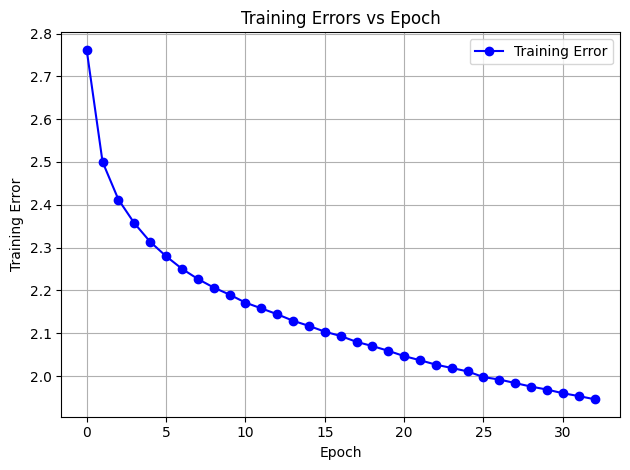

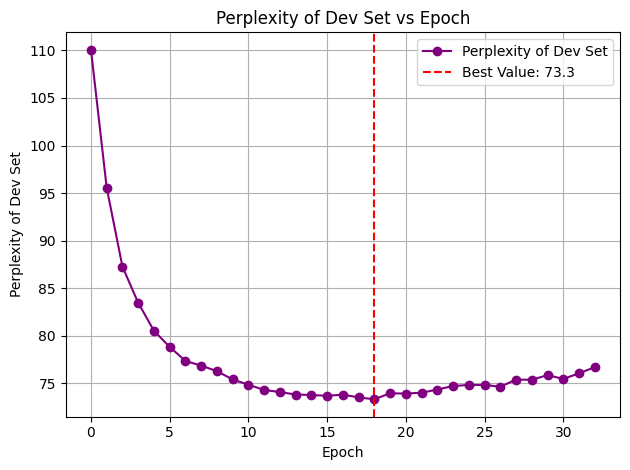

In [37]:
# Measuring the perplexity of the dev set
dev_set_perplexity = measure_perplexity(dev_x_indexes, dev_y_indexes, language_model, index_mapping=token2index)

# Displaying the perplexity of the dev set
print('\033[35m' + 'The perplexity of the dev set on the language model is:' + '\033[0m' + ' {:.1f}'.format(dev_set_perplexity))

plot_list(train_errors, 'Training Errors vs Epoch', 'Epoch', 'Training Error', 'blue', 'Training Error', show_best_value=False)
plot_list(dev_perplexities, 'Perplexity of Dev Set vs Epoch', 'Epoch', 'Perplexity of Dev Set', 'purple', 'Perplexity of Dev Set')

4.2) Now measure the space saving amount of the trained model on the test text.
Also check that when you decompress the compressed test text, you get exactly the same string as the test text.

Note: You may need to strip off the new line character from the end of the test text when comparing it to the decompressed text.

In [38]:
# Calculating the space saved by the language model on the test set mentioned above
space_saved = calculate_space_saving(test_set, language_model, index_mapping=token2index)
print(f'\033[1m' + 'The space saving of the language model on the test set:' + '\033[0m' + ' {:.1%}'.format(space_saved))

# Checking the compression and decompression of the test set
compressed_test_set = compress(test_set, language_model, index_mapping=token2index)
decompressed_test_set = decompress(compressed_test_set, language_model, index_mapping=token2index)

assert decompressed_test_set == test_set, 'Decompressed text is not the same as the original text.'
print('\033[1m' + 'Correct!' + '\033[0m')

The space saving of the language model on the test set: 3.7%
Correct!


4.3) Now you need to analyse the model's output.
Split the test text into sentences and compress each individual sentence.
Print out the top 5 most compressed sentences and the top 5 least compressed sentences according to the space saving metric together with the compressed sentences.

In [39]:
def analyse_output(model, test_set, index_mapping):
    """Analyzes the output of the given model on the given test set.

    Args:
        model: The language model.
        test_set (str): The test set.
        index_mapping (dict): A dictionary mapping tokens to indices.

    Returns:
        space_saved_dict (dict): A dictionary mapping sentences to the space saved by compressing the sentence.
    """
    # Setting variable for the print size
    print_size = 100

    # Creating a dictionary to store the space saved for each sentence
    space_saved_dict = {}

    # Splitting the test set into sentences
    sentences = test_set.split('\n')

    # Iterating through the sentences
    for sentence in sentences:
        # Calculating the space saved for the sentence
        space_saved = calculate_space_saving(sentence, model, index_mapping=index_mapping)

        # Adding the space saved to the dictionary
        space_saved_dict[sentence] = space_saved

    # Sorting the dictionary by the space saved
    sorted_space_saved_dict = sorted(space_saved_dict.items(), key=lambda x: x[1], reverse=True)

    # Printing the top 5 sentences with the most space saved
    print('\033[1m' + 'The top 5 sentences with the most space saved are:' + '\033[0m')
    print('-' * print_size)
    for i in range(5):
        print('\033[1m' + 'Sentence:' + '\033[0m' + ' {}'.format(i+1))
        print('\033[1m' + 'Original Sentence:' + '\033[0m' + ' {}'.format(sorted_space_saved_dict[i][0]))
        print('\033[1m' + 'Compressed Sentence:' + '\033[0m' + ' {}'.format(compress(sorted_space_saved_dict[i][0], model, index_mapping=index_mapping)))
        print('\033[1m' + 'Space Saved:' + '\033[0m' + ' {:.1%}'.format(sorted_space_saved_dict[i][1]))
        print('-' * print_size)

    print('\n'*3)
    
    # Printing the top 5 sentences with the least space saved
    print('\033[1m' + 'The top 5 sentences with the least space saved are:' + '\033[0m')
    print('=' * print_size)
    for i in range(1, 6):
        print('\033[1m' + 'Sentence:' + '\033[0m' + ' {}'.format(i))
        print('\033[1m' + 'Original Sentence:' + '\033[0m' + ' {}'.format(sorted_space_saved_dict[-i][0]))
        print('\033[1m' + 'Compressed Sentence:' + '\033[0m' + ' {}'.format(compress(sorted_space_saved_dict[-i][0], model, index_mapping=index_mapping)))
        print('\033[1m' + 'Space Saved:' + '\033[0m' + ' {:.1%}'.format(sorted_space_saved_dict[-i][1]))
        print('=' * print_size)

    # Returning the space saved dictionary
    return space_saved_dict

In [40]:
# Analyzing the output of the language model on the test set
space_saved_dict = analyse_output(language_model, test_set, index_mapping=token2index)

The top 5 sentences with the most space saved are:
----------------------------------------------------------------------------------------------------
Sentence: 1
Original Sentence: 3 4 . 6 % of all households were made up of individuals , and 1 5 . 7 % had someone living alone who was 6 5 years of age or older .
Compressed Sentence: 3 4 . 6 X X all X X X X X X , X X 5 X 7 X had X X X X X X X years X X or X X
Space Saved: 42.4%
----------------------------------------------------------------------------------------------------
Sentence: 2
Original Sentence: hispanic or latino of any race were 3 . 0 0 % of the population .
Compressed Sentence: hispanic X X X X X X 3 X 0 0 % X X X X
Space Saved: 41.5%
----------------------------------------------------------------------------------------------------
Sentence: 3
Original Sentence: the average household size was 2 . 6 1 and the average family size was 2 . 9 4 .
Compressed Sentence: X average X X X X X 6 1 and the X X X X X X X 4 X
Space 

4.4) Is the reason for whether a sentence is compressible or not due to its similarity to the train set (a sentence that is similar to one in the train set would be easier to predict and thus more tokens will be compressed)?
Find out the answer to this by doing the following:

Extract all the trigrams from the train set (you can use `nltk.trigrams` to do this).
For each sentence in the test set, count how many of its trigrams are also found in the train set.
Turn this count into a domain similarity measure by dividing it by the number of trigrams in the test sentence.

Note: In order for this fraction to be meaningful from the language model's point of view, the edge token must be added to the front of the test sentences and out-of-vocabulary tokens must be replaced with the unknown token.

Create a list that maps each sentence's domain similarity to its space saving amount.
Plot a scatter plot showing how the domain similarity measure relates to the space saving amount of each test sentence.
If there is a correlation between these two measures, then the points in the scatter plot will form approximately into a straight line.

In [41]:
def plot_domain_similarity_vs_space_saved(train_set, test_set, vocabulary, space_saved_dict, color='blue', legend_label='Data Points', linestyle='-', marker='o'):
    """Plots a graph of the domain similarity vs the space saved for the given train and test sets.

    Args:
        train_set (str): The train set.
        test_set (str): The test set.
        vocabulary (list): A list of the vocabulary tokens.
        space_saved_dict (dict): A dictionary mapping sentences to the space saved by compressing the sentence.
        color (str): The color of the markers (default: 'blue').
        legend_label (str): The legend label for the plot (default: 'Data Points').
        linestyle (str): The line style (default: '-').
        marker (str): The marker style (default: 'o', set 'None' to remove markers).
    
    Returns:
        domain_similarities (list): A list of the domain similarities for each sentence in the test set.
    """
    # Splitting the train set into sentences
    train_sentences = train_set.split('\n')

    # Splitting the test set into sentences
    test_sentences = test_set.split('\n')

    # Extracting the tokens from the train set based on the vocabulary, whilst adding the edge token to the beginning of each sentence
    train_tokens = [token if token in vocabulary else UNKNOWN_TOKEN for sentence in train_sentences for token in [EDGE_TOKEN] + sentence.split()]

    # Extracting the trigrams from the train set 
    train_trigrams = set(nltk.trigrams(train_tokens))
    
    # Calculating the trigram counts for the train set
    trigram_counts = Counter(train_trigrams)

    # Declaring a list to store the domain similarities
    domain_similarities = []
    
    # Iterating through the test sentences
    for sentence in test_sentences:
        # Error handling for empty sentences
        if not sentence:
            continue
        
        # Adding the edge token to the beginning of the sentence, and converting the sentence to a list of tokens depending on the vocabulary
        sentence = [EDGE_TOKEN] + [token if token in vocabulary else UNKNOWN_TOKEN for token in sentence.split()]

        # Calculating the trigrams for the sentence
        sentence_trigrams = list(nltk.trigrams(sentence))

        # Calculating the domain similarity for the sentence
        count = sum(trigram_counts[trigram] for trigram in sentence_trigrams if trigram in train_trigrams)

        # Appending the domain similarity to the list of domain similarities, by dividing the count by the number of trigrams in the sentence
        domain_similarities.append(count / len(sentence_trigrams))

    # Converting the list of domain similarities to a numpy array
    domain_similarities = np.array(domain_similarities)

    # Plotting the graph
    plt.figure(figsize=(15, 7))
    # Plotting best fit line
    plt.plot(np.unique(domain_similarities), np.poly1d(np.polyfit(domain_similarities, [space_saved_dict[sentence] for sentence in test_sentences], 1))(np.unique(domain_similarities)), color='red', linestyle='--', label='Best Fit Line')
    plt.scatter(domain_similarities, [space_saved_dict[sentence] for sentence in test_sentences], color=color, linestyle=linestyle, marker=marker, label=legend_label)
    plt.title('Domain Similarity vs Space Saved')
    plt.xlabel('Domain Similarity')
    plt.ylabel('Space Saved')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Returning the list of domain similarities
    return domain_similarities

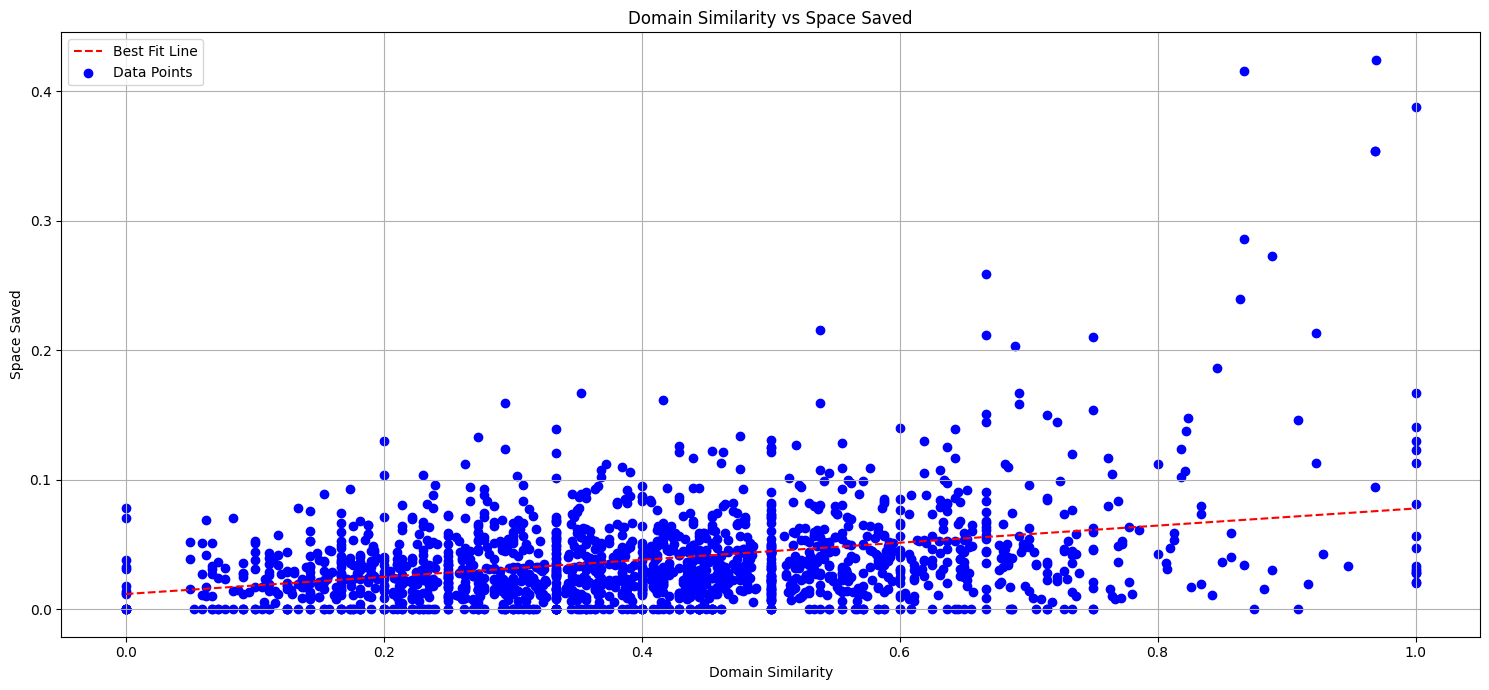

In [42]:
# Loading the train set as text
train_set = load_into_string('train.txt')

# Plotting the graph
domain_similarities = plot_domain_similarity_vs_space_saved(train_set, test_set, train_vocab, space_saved_dict) 

4.5) The scatter plot should not have created a straight line and should show a lot of bias towards very low space saving amounts, regardless of domain similarity.
Why is domain similarity not enough for explaining the compressability?

<hr>
<font size="+3"><center><b>Anwser:</b></center></font>
<br>

**Domain similarity** is insufficient to explain compressibility as compressibility is `not solely based on the similarity of the test sentence to the train set`. Moreover, some factors that may affect compressibility, which are not captured by the domain similarity measure are:
* The length of the sentence.
* The language used in the sentence.
* The complexity of the sentence.
* Repeated word patterns in the sentence.
* The size of the dataset used to train the model.
* The compression algorithm utilised.

Additionally, the language model is able to predict the next token based on prior tokens in the sentence, instead of just the previous two tokens (per-trigram). Hence, this discrepancy between the domain similarity measure and the language model can be illustrated in the above scatter plot.


<hr>

## 5) Conclusions (10%)

Write the following conclusions:

5.1) What is a simple change in the compression algorithm that can be made to increase compression?
Do not suggest any fundamental changes; the algorithm must still work by predicting missing tokens.

<hr>
<font size="+3"><center><b>Anwser:</b></center></font>
<br>

The compression algorithm can be improved by encoding common phrases as a single token. This approach reduces the vocabulary size by replacing common phrases with a single representative token or code while retaining the algorithm's predictive capabilities. For example, the common phrase `"the dog"` can be encoded as a single token or code, thus the phrase `"the dog bit the cat"` can be compressed to `"X bit X cat"` by replacing the phrase "the dog" with a single token or code.

<hr>

5.2) Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about English sentences.

<hr>
<font size="+3"><center><b>Anwser:</b></center></font>
<br>

The results of the **Neural Language Model** suggest that the model is capable of compressing text by replacing predictable tokens with the single letter `'X'`. Although there wasn't a significant improvement in the space saving amount of the neural language model, when compared to the mock model, the space saving amount of the neural language model was still higher than the mock model. This is evident from the percentage shit from the `2.4%` achieved by the mock model to a new range of `3.5%` to `3.8%` attained by the language model.

Nevertheless, it was also apparent that the neural language model's dev perplexity, having a range of `73.2` to `73.8` was significantly lower than the mock model's dev perplexity of `7062.2`. This significant improvement to the dev perplexity can be attributed to a number of reasons, those being:
* The utilization of a dropout layer, which prevents `overfitting`.
* Applying a weight decay to the optimizer, which prevents `overfitting`.
* Applying early stopping to prevent `overfitting`.
* Applying gradient clipping to the optimizer to prevent `exploding gradients`.
* Performing hyperparameter tuning to find the `best hyperparameters` for the model.

Moreover, as illustrated by the training error and perplexity curves, the model avoids overfitting due to its gradual descent and consistent learning behaviour.

With regards to whether the model is learning anything "deep" about English sentences, it is likely that the model is learning some patterns and structures inherent in the English language, such as common phrases or grammatical structures. However, it is impossible to judge how far this comprehension goes without a more thorough examination of the model's predictions.

In terms of architectural improvements, a more sophisticated language model could be used, such as a `transformer model`. Furthermore, the model could also be trained on a more diversified dataset, allowing it to understand additional patterns and structures inherent in the English language. In addition, another approach to improving the model's performance can be attributed to adjusting the token omission threshold with the aim of increasing the space saving amount. Lastly, to ensure that the compressed text keeps the same meaning as the original text, a semantic similarity metric could potentially be incorporated.

<hr>